# Bayesian estimation for multivariate Ornstein-Uhlenbeck (MOU) model

Andrea Insabato, John P. Cunningham, Matthieu Gilson

@author: andrea.insabato@upf.edu

When using models two things are important: richness of model dynamics and robustness of estimation method.

Here we compare three different estimation method for MOU: moments, gradient-based and Bayesian.

### Why Bayesian?
* connectivity detection: posterior probability of parameters $\Theta$, $p(\Theta | X)$, allows to make statistical test about the existence of any connection in the network
* inclusion of prior over parameters acts as a regularization that can improve reliability when few samples are available
* model comparison (e.g. MOU, dynamic mean-field, Hopf, etc.)

In [1]:
# execute this cell first to import all necessary libraries

from MOU import MOU, make_rnd_connectivity
from scipy.io import loadmat
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

## MOU

## Univariate

The univariate OU model is a stochastic process whose dynamics tends towards a mean value

$ \frac{dx}{dt} = -\frac{x}{\tau_x} + \mu + \sigma \frac{dB}{dt} $

You can vary the noise, input and time constant in the cell below to see how they affect the dynamics.

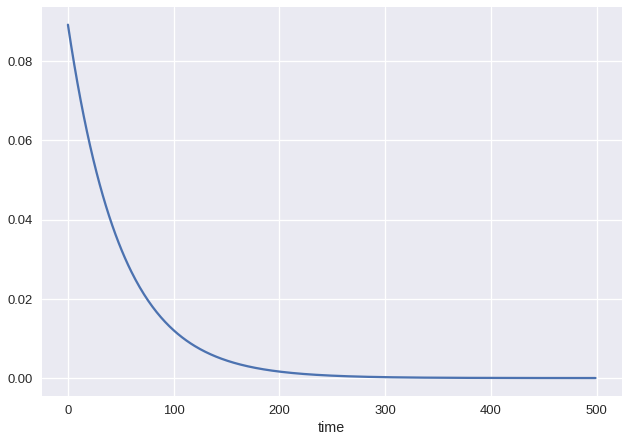

In [20]:
model = MOU(n_nodes=1, tau_x=50, mu=0.0, Sigma=1e-18)
ts = model.simulate(T=500)
plt.figure()
plt.plot(ts)
plt.xlabel('time')
plt.show()

## Multivariate

In multivariate OU each node alse receives input from all other connected nodes. Here the noise is considered to be uncorrelated between nodes but it can be easy generalized to correlated noise.

Dynamics of each node i in the network:
$ \frac{dx_i}{dt} = -\frac{x_i}{\tau_x} + \sum_{j\ne i}^M C_{ij} x_j + \mu_i + \sigma_i \frac{dB_i}{dt} $

### Random connectivity matrix

In order to simulate the MOU we need to define a connectivity matrix. Here we use a random connectivity matrix given by the Hadamard (element-wise) product of a binary adjacency matrix and a log-normal weight matrix.

$$ C' = A \otimes W $$
where $ A\sim Bern(p)$ and $ ln W \sim \mathcal{N}(0,1)$

When varying the number of nodes C' gets normalized in order to avoid explosion of activity.
$$ C = \frac{C' N}{\sum_{i,j} C'} $$

The following cell creates a connectivity matrix and runs a simulation of the corresponding network.

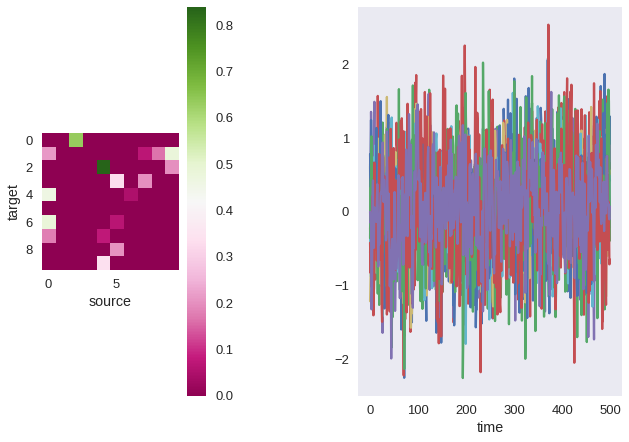

In [3]:
sns.set_style('dark')
C = make_rnd_connectivity(N=10, density=0.2)
model = MOU(n_nodes=10, tau_x=1, mu=0.0, Sigma=None, C=C, random_state=0)
ts = model.simulate(T=500, random_state=0)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(C, cmap='PiYG')
plt.xlabel('source')
plt.ylabel('target')
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(ts)
plt.xlabel('time')
plt.show()

## Estimation

Here we outline the basic steps to estimate MOU parameters.

### Forward step (calculate covariances given parameters )
The Jacobian of the system is: $ J_{ij} = -\frac{\delta_{ij}}{\tau_x}C_{ij}$, where $\delta_{ij}$ is Kronecker's delta.
Deriving the covariance of the system we obtain the Lyapunov equation: $ JQ^0 + Q^0J^T + \Sigma = 0 $, where $\Sigma$ is the diagonal matrix $\Sigma_{ii} = \sigma_i$.
From this equation the vectorized covariance can be calculated as: 
$$ vec(Q^0) = -\frac{vec(\Sigma)}{I_M \otimes J + \tilde{J} \otimes I_M}$$

where $\tilde{A}$ indicates the matrix of complex conjugate elements of $A$.

Similarly the derivation of the time-lagged covariance for lag $\tau$ yealds:
$$ Q^{\tau} = Q^0 expm(J^T\tau)$$

These equations allow to compute the farward step: calculate (time-lagged) covariance matrix knowing the parameters of the system $\theta: \{C, \Sigma, \tau_x\}$.

### Parameter estimation
#### Moments method
From [Gilson et al. (PLoS Comp Bio, 2016)](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004762).

In order to estimate the parameters $\theta$ we can apply the moments method.
We can use the empirical covariances $\hat{Q}^0$, $\hat{Q}^{\tau}$ and last equation to get:
$$ \hat{J} = \frac{1}{\tau} \Bigl[logm(\hat{Q}^{\tau}(\hat{Q}^0)^{-1})\Bigr]^{T}  $$
An estimate of $\Sigma$ can then be calculated from Lyapunov equation above:
$$ \hat{\Sigma} = -\hat{J}\hat{Q}^0 - \hat{Q}^0 \hat{J}^T $$

#### Natural Gradient Optimization:
From [Gilson et al. (PLoS Comp Bio, 2016)](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004762).

Lyapunov function:
$$ V(C) = (Q^0-\hat{Q}^0)^2 + (Q^{\tau}-\hat{Q}^{\tau})^2 $$

Parameters update:
$$ \Delta J = \frac{1}{\tau} \Bigl[(Q^0)^{-1} (\Delta Q^0 + \Delta Q^{\tau} expm(-J^T \tau)) \Bigr]^T$$
$$\Delta \Sigma = -\hat{J}\Delta Q^0 - \Delta Q^0 \hat{J}^T$$

#### Bayesian approach
[From Singh et al. (arxiv, 2017)](https://arxiv.org/abs/1706.04961).

The probability of the state of the system at time $t'$ give its state at time $t$ is given by:
$$ x(t'|t) \sim \mathcal{N}\Bigl(expm(J\Delta t)x(t), \Xi \Bigr)$$
where $\Xi = Q^0 - expm(J\Delta t) Q^0 expm(J \Delta t)^T$ and $\Delta t = t'-t$.

The stationary distribution is: $x \sim \mathcal{N}(0, Q^0)$.

Given a dataset where x is sampled at regular intervals $x^1, x^2,\dots, x^N$, and $X$ is the $M$ times $N$ matrix collecting all the $N$ observations for each of the $M$ nodes, the likelihood function is given by:
$$p(X|\theta) = \prod_n^N p(x^{n+1} | x^n, \theta)p(x^1|\theta)$$
Then the posterior distribution of parameters is given by:
$$ p(\theta|X)=\frac{p(X|\theta)p(\theta)}{p(X)}$$

The log posterior, substituting the explicit pdfs, is:
$$ ln p(\theta|X) = -\frac{1}{2} \sum_n^N \Delta_n^T \Xi \Delta_n -\frac{1}{2} (x^1)^T (Q^0)^{-1} x^1 + \frac{N-1}{2} ln \frac{1}{(2\pi)^M |\Xi|} + \frac{1}{2} ln \frac{1}{(2\pi)^M |Q^0|} $$

where $\Delta_n = x^{n+1}+Jx^n$.

Taking the derivative of the log posterior and setting to zero the value of the parameters can be calculated; this yields the _maximum a posteriori_ or MAP solution. 

Defining $T^0 = \sum^N x^n(x^n)^T $ and $T^1 = \sum^N x^{n+1}(x^n)^T $, the MAP solution for $\Lambda=exmp(J \Delta t)$ is:
$\hat{\Lambda} = T^1 (T^0)^{-1}$ ($\Xi$ can also be estimated with the same method but we don't pursue it here since it is not related to connectivity estimation).

It follows than that:
$$ \hat{J} = \frac{logm(\hat{\Lambda})}{\Delta t} $$

Sigma can then be estimated again from the Lyapunov equation:
$$ \hat{\Sigma} = -\hat{J}\hat{Q}^0 - \hat{Q}^0 \hat{J}^T $$

It can be easily seen that the Bayesian and the moments methods yield the same solution. Hence in the following we use the label "moments method" indicates both moments and Bayesian methods. In addition since the Bayesian method used assumes a flat prior the Bayesian solution also coincides with the maximum likelihood solution.

## Estimation accuracy varying M (with synthetic data)

For a fixed amount of data a model with less parameters can be estimated with a higher precision than one with more parameters.
Here we show how the size of the network $M$ influences the accuracy of the estimation.
For a given size $M$ we draw a connectivity matrix and simulate the model for 500 time steps. Then we estimate the connectivity from the simulated time series using lyapunov and moments methods. Finally we calculate Pearson's correlation coefficient between the "true" connectivity (used to generate the time series) and the estimated connectivity, as a measure of the accuracy of estimation. 

We repeat these steps 100 times for each value of $M$.

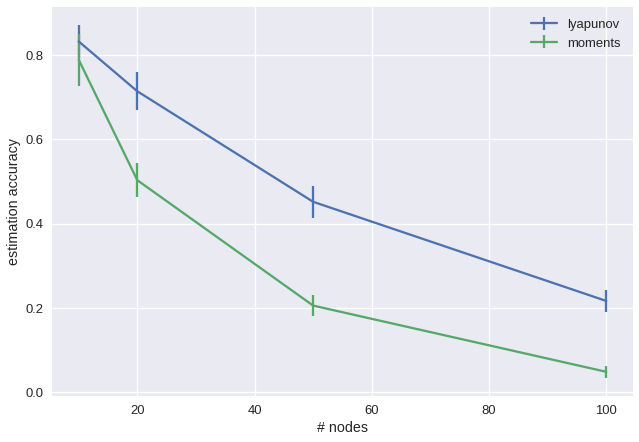

In [9]:
sns.set_style('darkgrid')
Ms = [10, 20, 50, 100]
repetitions = 10  # 10 repetitions already gives a good idea of variability with small execution time (few seconds for each M)
rCl = np.zeros([len(Ms), repetitions])
rCm = np.zeros([len(Ms), repetitions])
for i, M in enumerate(Ms):
    for r in range(repetitions):
        # create generative connectivity matrix
        C = make_rnd_connectivity(N=M, density=0.2, connectivity_strength=0.5)
        # simulate time series
        ts = MOU(n_nodes=M, tau_x=1, mu=0.0, Sigma=None, C=C).simulate(T=500)
        # instantiate the model with the two estimation methods and fit them
        model_l = MOU(n_nodes=M, tau_x=1, mu=0.0).fit(X=ts, method="lyapunov")
        model_m = MOU(n_nodes=M, tau_x=1, mu=0.0).fit(X=ts, method="moments")
        # compute estimation accuracies
        rCl[i, r] = pearsonr(model_l.C.flatten(), C.flatten())[0]
        rCm[i, r] = pearsonr(model_m.C.flatten(), C.flatten())[0]
plt.figure()
plt.errorbar(Ms, rCl.mean(axis=1), rCl.std(axis=1), label='lyapunov')
plt.errorbar(Ms, rCm.mean(axis=1), rCm.std(axis=1), label='moments')
plt.xlabel('# nodes')
plt.ylabel('estimation accuracy')
plt.legend()
plt.show()

As can be seen, except for very small networks, the gradient-based method outperforms the moments method.

## Estimation accuracy varying T (fixed M)

Here we show how the amount of data available influences the accuracy of the estimation.
For a given number of time samples $N$ we draw a connectivity matrix and simulate the model with 50 nodes. Then we estimate the connectivity from the simulated time series using lyapunov and moments methods. Finally we calculate Pearson's correlation coefficient between the "true" connectivity (used to generate the time series) and the estimated connectivity, as a measure of the accuracy of estimation. 

We repeat these steps 100 times for each value of $N$.

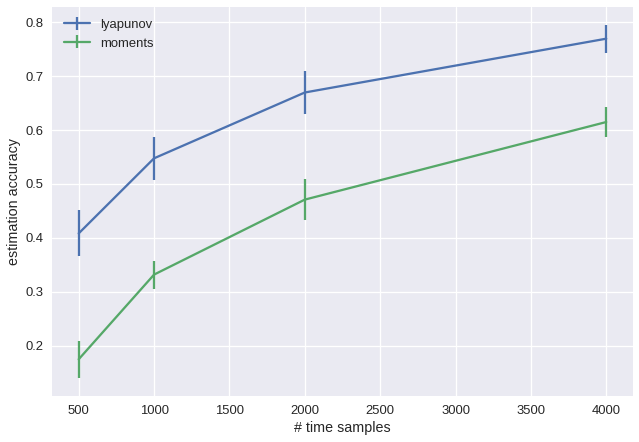

In [10]:
M = 50
Ts = [500, 1000, 2000, 4000]
repetitions = 10
rCl = np.zeros([len(Ts), repetitions])
rCm = np.zeros([len(Ts), repetitions])
for i, T in enumerate(Ts):
    for r in range(repetitions):
        # create generative connectivity matrix
        C = make_rnd_connectivity(N=M, density=0.2, connectivity_strength=0.5)
        # simulate time series
        ts = MOU(n_nodes=M, tau_x=1, mu=0.0, Sigma=None, C=C).simulate(T=T)
        # instantiate the model with the two estimation methods and fit them
        model_l = MOU(n_nodes=M, tau_x=1, mu=0.0).fit(X=ts, method="lyapunov")
        model_m = MOU(n_nodes=M, tau_x=1, mu=0.0).fit(X=ts, method="moments")
        # compute estimation accuracies
        rCl[i, r] = pearsonr(model_l.C.flatten(), C.flatten())[0]
        rCm[i, r] = pearsonr(model_m.C.flatten(), C.flatten())[0]
plt.figure()
plt.errorbar(Ts, rCl.mean(axis=1), rCl.std(axis=1), label='lyapunov')
plt.errorbar(Ts, rCm.mean(axis=1), rCm.std(axis=1), label='moments')
plt.xlabel('# time samples')
plt.ylabel('estimation accuracy')
plt.legend()
plt.show()

## Connectivity estimated from data

In the two previous sections the connectivity matrix of the generative model was sampled from a predefined distribution.

In order to study a case nearer to experimental data here we estimate the connectivity matrix from the BOLD time series of an fMRI recording sessions. We then use this connectivity matrix to generate a time series using the MOU.

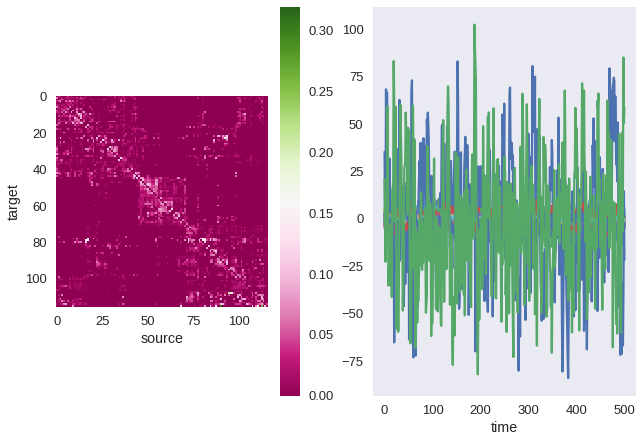

In [12]:
sns.set_style('dark')
# load BOLD time series
data = np.loadtxt('ROISignals_0025427_SE01.txt')
# load structural connectivity mask
mask_AAL = np.array(loadmat('/home/andrea/Work/vicente/mask_EC_AAL.mat')['mask_EC'], dtype=bool)
model = MOU(n_nodes=116)
model.fit(X=data, SC_mask=mask_AAL)
Cemp = model.C
plt.figure()
plt.subplot(1,2,1)
plt.imshow(Cemp, cmap='PiYG')
plt.xlabel('source')
plt.ylabel('target')
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(model.simulate(T=500))
plt.xlabel('time')
plt.show()

## Estimation varying T (with empirical connectivity)

We now show how the amount of data available influences the accuracy of the estimation, when the generative connectivity matrix is that estimated from real data.
For a given number of time samples $N$ we simulate the model using the connectivity matrix estimated from real data. Then we estimate the connectivity from the simulated time series using lyapunov and moments methods. Finally we calculate Pearson's correlation coefficient between the "true" connectivity (used to generate the time series) and the estimated connectivity, as a measure of the accuracy of estimation. 

We repeat these steps 100 times for each value of $N$.

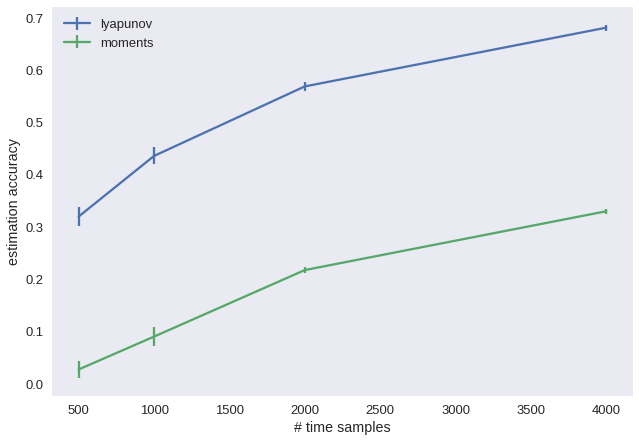

In [15]:
sns.set_style('darkgrid')
M = 116
Ts = [500, 1000, 2000, 4000]
repetitions = 10
file_name = "comparison_N116_empC.npy"
file = np.load(file_name)
gen = file[0]
lyap = file[1]
mome = file[2]
rCl = np.zeros([len(Ts), repetitions])
rCm = np.zeros([len(Ts), repetitions])
for i, T in enumerate(Ts):
    for r in range(repetitions):
        # simulate model with connectivity Cemp (calculated in previous cell)
        ts = MOU(n_nodes=M, tau_x=1, mu=0.0, Sigma=None, C=Cemp).simulate(T=T)
        # instantiate the model with the two estimation methods and fit them
        model_l = MOU(n_nodes=M, tau_x=1, mu=0.0).fit(X=ts, method="lyapunov")
        model_m = MOU(n_nodes=M, tau_x=1, mu=0.0).fit(X=ts, method="moments")
        # compute estimation accuracies
        rCl[i, r] = pearsonr(model_l.C.flatten(), Cemp.flatten())[0]
        rCm[i, r] = pearsonr(model_m.C.flatten(), Cemp.flatten())[0]
plt.figure()
plt.errorbar(Ts, rCl.mean(axis=1), rCl.std(axis=1), label='lyapunov')
plt.errorbar(Ts, rCm.mean(axis=1), rCm.std(axis=1), label='moments')
plt.xlabel('# time samples')
plt.ylabel('estimation accuracy')
plt.legend()
plt.show()

## Application to subjective identity classification

Beyond mathematical beauty and explanatory value a model should be useful for something. So a better estimation procedure should also give an advantage when using the model.

In the following we chose as an application the classification of "cognitive states". For this we used a dataset where 19 subject underwent 3 fMRI scanning sessions in resting state condition and 2 sessions while watching a movie.
For each subject and session we estimate the connectivity with either the moments or the gradient-based method. We then classify the condition ("resting", "movie") using the values of estimated connectivity.

This objective was already pursued in [Pallares et al. (Bioarxiv, 2017)](https://www.biorxiv.org/content/early/2017/10/11/201624). Here we use a less sophisticated method applying only a multinomial logistic regression to the z-scored data. The classification accuracy for the "cognitive" condition is calculated on 20% randomly splitted data (not used for training). We repeated 100 times the random splitting.

The following cell shows the distribution of classification accuracies across repetitions of the random splitting for the two methods.
As can be seen the higher reliability of lyapunov method is reflected in higher classification accuracies.

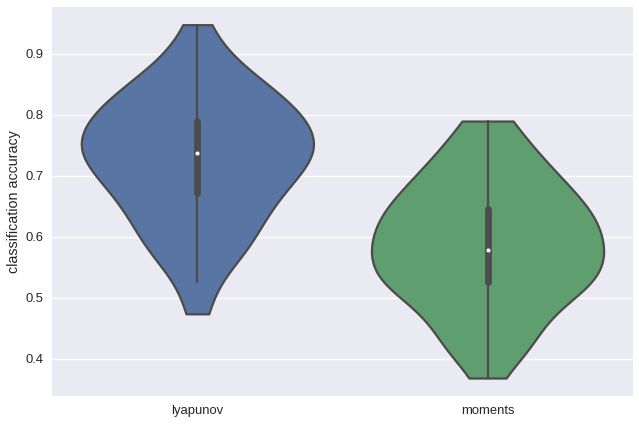

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

######## Estimate connectivity from data ############
# load dataset
ts_movie = np.load('/home/andrea/Work/vicente/data/movie/ts_emp.npy')    
# remove bad subjects: 1 11 19
ts_clean = np.delete(ts_movie, [0, 10, 18], 0)
# load Hagmann SC mask
movMask = np.load('/home/andrea/Work/vicente/mask_EC.npy')  # [roi, roi] the mask for existing EC connections
models_l = dict()
models_m = dict()
# estimate connectivity
for sb in range(19):  # subjects loop
    models_l[sb] = dict()
    models_m[sb] = dict()
    for ss in range(5):  # sessions loop
        BOLD_ts = ts_clean[sb, ss, :, :].T
        models_l[sb][ss] = MOU(n_nodes=66)
        models_l[sb][ss].fit(X=BOLD_ts, method="lyapunov", SC_mask=movMask)
        models_m[sb][ss] = MOU(n_nodes=66)
        models_m[sb][ss].fit(X=BOLD_ts, method="moments", SC_mask=movMask)
#####################################################


############ data matrix for classification   ##############
Xl = np.zeros([19*5, np.sum(movMask.flatten())])
Xm = np.zeros([19*5, np.sum(movMask.flatten())])
i = 0
for sb in range(19):  # subjects loop
    for ss in range(5):  # sessions loop
        Xl[i, :] = models_l[sb][ss].C[movMask].flatten()
        Xm[i, :] = models_m[sb][ss].C[movMask].flatten()
        i += 1
# labels
y = np.array([0 if sess_id<2 else 1 for i in range(19) for sess_id in range(5)])  # labels
#####################################################

# classifier instantiation
clf = LogisticRegression(C=10000, penalty='l2', multi_class= 'multinomial', solver='lbfgs')
# corresponding pipeline: zscore and pca can be easily turned on or off
pipe_l = Pipeline([('zscore', StandardScaler()),
                         ('clf', clf)])
pipe_m = Pipeline([('zscore', StandardScaler()),
                         ('clf', clf)])
repetitions = 100  # number of times the train/test split is repeated
# shuffle splits for validation test accuracy
shS = ShuffleSplit(n_splits=repetitions, test_size=None, train_size=.8, random_state=0)

score_l = np.zeros([repetitions])
score_m = np.zeros([repetitions])

######## Cross-validation ##################
i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(Xl):  # repetitions loop
    data_trainl = Xl[train_idx, :]
    data_trainm = Xm[train_idx, :]
    y_train = y[train_idx]
    data_testl = Xl[test_idx, :]
    data_testm = Xm[test_idx, :]
    y_test = y[test_idx]
    pipe_l.fit(data_trainl, y_train)
    pipe_m.fit(data_trainm, y_train)
    score_l[i] = pipe_l.score(data_testl, y_test)
    score_m[i] = pipe_m.score(data_testm, y_test)
    i+=1
#############################################

# plot comparison as violin plots
fig, ax = plt.subplots()
sns.violinplot(data=[score_l, score_m], cut=0, orient='v', scale='width')
ax.set_xticklabels(['lyapunov', 'moments'])
plt.ylabel('classification accuracy')
plt.show()